# The Ocean Grid

Working with model output on the ocean grid, with its rotated pole, presents an additional challenge. You cannot use the standard python packages to do this, and must use the `geog0121` virtual environment instead.

### Import packages and define fucntions for calculations

In [1]:
'''Import packages for loading data, analysing, and plotting'''

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma


import os
import matplotlib.colors as colors

import scipy
from cartopy.util import add_cyclic_point
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


# Sea ice

In [2]:
variable_name='sic_nh_spatialmean_ann'

period1='1851-1900'
ssp1='ssp585'

directory1='/data/aod/cvdp_cmip6/geog0121/UKESM1-0-LL_ssps.wrt_%s' %period1
filename_a='%s/UKESM1_%s_%s.cvdp_data.1850-2100.nc'%(directory1,ssp1,period1)

period2='2071-2100'
ssp2='ssp585'
directory2='/data/aod/cvdp_cmip6/geog0121/UKESM1-0-LL_ssps.wrt_%s' %period2
filename_b='%s/UKESM1_%s_%s.cvdp_data.1850-2100.nc'%(directory2,ssp2,period2)

In [3]:
#This cell will calculate the difference between two experiments
expt_a_file=xr.open_dataset(filename_a,decode_times=False)
expt_a=expt_a_file[variable_name]

expt_b_file=xr.open_dataset(filename_b,decode_times=False)
expt_b=expt_b_file[variable_name]

In [4]:
# coordinates
lon2d=expt_a_file['lon2d_ice_nh']
lat2d=expt_a_file['lat2d_ice_nh']

In [5]:
expt_a

<xarray.DataArray 'sic_nh_spatialmean_ann' (j: 330, i: 360)>
[118800 values with dtype=float32]
Coordinates:
  * i        (i) int32 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
  * j        (j) int32 0 1 2 3 4 5 6 7 8 ... 321 322 323 324 325 326 327 328 329
Attributes:
    coordinates:     type latitude longitude
    history:         2019-04-05T15:48:59Z altered by CMOR: Converted units fr...
    original_units:  1
    original_name:   mo: (variable_name: aice)
    units:           %
    comment:         Area fraction of grid cell covered by sea ice
    long_name:       Northern Hemisphere sic mean (annual)
    standard_name:   sea_ice_area_fraction

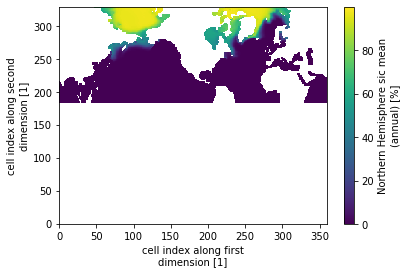

In [6]:
expt_a.plot()

The default plot of this variable above demonstrates both the odd grid, and the fact that we only have data in the northern hemisphere. In fact the latitudes and longitudes of each grid point are shown in the figures below

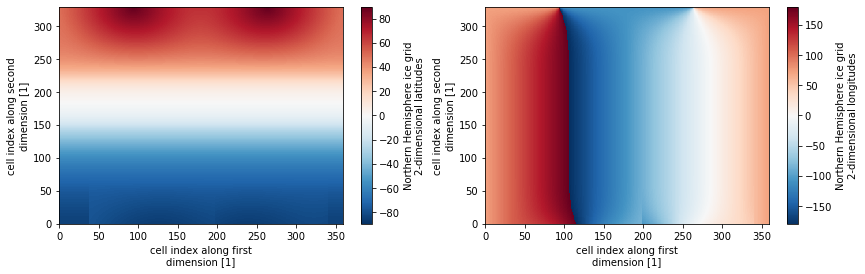

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
lat2d.plot(ax=ax1)
lon2d.plot(ax=ax2)

In [8]:
#remove all 0 
ice=expt_a.where(expt_a>0)

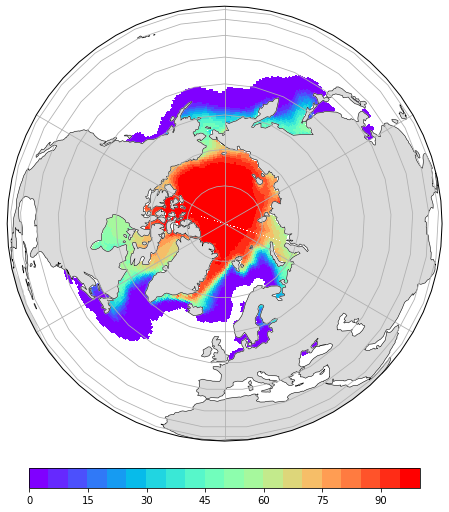

In [9]:
cmap=plt.get_cmap('rainbow')
projection = ccrs.PlateCarree(central_longitude=0.0, globe=None)

transform=ccrs.PlateCarree()

bounds = np.linspace(0, 100, 21)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)



plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=90.0))
ax.add_feature(cartopy.feature.LAND, zorder=1,facecolor=cartopy.feature.COLORS['land_alt1'])
ax.coastlines(resolution='110m', linewidth=0.5)
ax.gridlines()

fig=ax.pcolormesh(lon2d,lat2d,ice, transform=transform,cmap=cmap,norm=norm)

#add bounday of expt_b
#ax.contour(lon_nh,lat_nh,expt_b, colors='black', levels=[1], linewidth=4, transform=transform)

cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)

plt.colorbar(fig,cax=cax,**kw)


# Sea surface temperature

In [10]:
variable_name='tos'
filename_a='/data/CMIP/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Omon/tos/gn/v20190406/tos_Omon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc'
filename_b='/data/CMIP/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r1i1p1f2/Omon/tos/gn/v20190510/tos_Omon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_205001-210012.nc'

expt_a_file=xr.open_dataset(filename_a,decode_times=False)
expt_a=expt_a_file[variable_name]

expt_b_file=xr.open_dataset(filename_b,decode_times=False)
expt_b=expt_b_file[variable_name]

#2D coordinates
latitude=expt_a_file['latitude']
longitude=expt_a_file['longitude']

In [11]:
# Now we take the time-averages
mn_a=np.average(expt_a,axis=0)
mn_b=np.average(expt_b,axis=0)

diff=mn_b-mn_a

Having now created the field to actually plot, let's get on doing so

In [12]:
#temperatures
cmap=plt.get_cmap('bwr') #define colormap

#define colormap's range and scale
clim=[-6,6]
bounds = np.linspace(clim[0], clim[1], 21)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

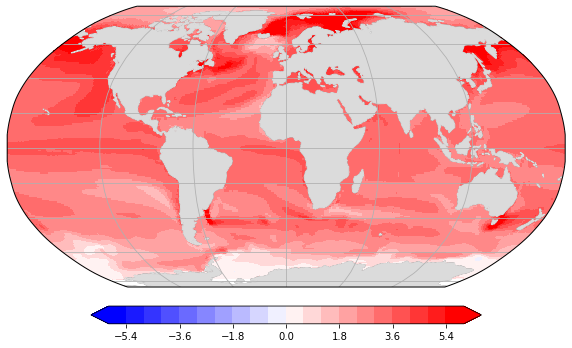

In [13]:
#Global map

projection = ccrs.Robinson()
transform=ccrs.PlateCarree()

plt.figure(figsize=(10,7))
ax = plt.axes(projection=projection)

ax.coastlines(resolution='110m', linewidth=0.5)
ax.gridlines()

fig=ax.pcolormesh(longitude,latitude,diff,transform=transform,cmap=cmap,norm=norm)
ax.add_feature(cartopy.feature.LAND, zorder=1,facecolor=cartopy.feature.COLORS['land_alt1'])
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
plt.colorbar(fig,cax=cax,extend='both',**kw)

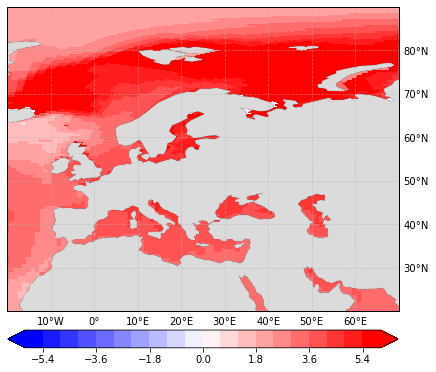

In [14]:
#Regional map
region=[-20,70,20,90] #[lon_min,lon_max,lat_min,lat_max]

projection = ccrs.PlateCarree(central_longitude=0.0, globe=None)
transform=ccrs.PlateCarree()

plt.figure(figsize=(10,7))
ax = plt.axes(projection=projection)

ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
#gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


fig=ax.pcolormesh(longitude,latitude,diff, transform=transform,cmap=cmap,norm=norm)
ax.add_feature(cartopy.feature.LAND, zorder=1,facecolor=cartopy.feature.COLORS['land_alt1'])
ax.set_extent(region, ccrs.PlateCarree())

cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
plt.colorbar(fig,cax=cax,extend='both',**kw)

#plt.savefig(figname)